In [1]:
import kwant
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
from dask_quantumtinkerer import Cluster, cluster_options
import dask.bag as db
import itertools as it
from scipy.sparse import csc_matrix
import scipy.sparse.linalg as sla
import scipy.linalg as la
from collections import OrderedDict
import matplotlib

import ccode.finite_system as tj
import ccode.tools as tl
import ccode.solvers as sl
import ccode.plotting as pt

%matplotlib inline

/opt/conda/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [175]:
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [203]:
matplotlib.rcParams.update({'font.size': 16})

In [177]:
directory_path = '../data/manuscript/phases'
os.system('mkdir '+directory_path)

0

In [194]:
a = 10e-9
titles = ['left-right', 'left-center', 'center-right']

In [83]:
options = cluster_options()
options.worker_cores = 1  # you should always leave this to 1 (I think)
options.worker_memory = 2  # Need to atdjust this to meet your needs
options.extra_path = "/home/jtorresluna/trijunction_design/"

# Short and long junctions

In [143]:
width = 20*a
center = [-width/4, width/4]
geometry = {
    "l": 130*a,
    "w": 7*a,
    "a": a,
    "side": 'up',
    "shape": 'rectangle',
    "L": 15*a,
    "W": width,
    "centers": center
}

In [144]:
trijunction, f_params, _ = tj.finite_system(**geometry)
trijunction = trijunction.finalized()

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


(-1e-07, 2.5e-07)

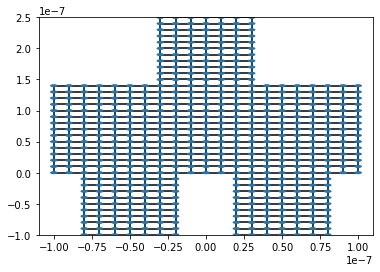

In [145]:
fig, ax = plt.subplots()
kwant.plot(trijunction, ax=ax)
ax.set_ylim(-1e-7, 2.5e-7)

In [146]:
n = 60
colors = ['black' for i in range(int(n/2-2))] + ['red', 'red']
colors += colors [::-1]

system = [trijunction, f_params]
eigen = sl.general_solver([system], n)


def wrap(args):
    return eigen(*args)

In [147]:
extra_params = sl.phase_params(key='sigma', param=0)

In [148]:
args = list(it.product([0], extra_params))
args_db = db.from_sequence(args, npartitions=20)

In [149]:
with Cluster(options) as cluster:
    cluster.scale(n=20)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

path = directory_path + '/short_junction.pickle'
with open(path, 'wb') as file:
    pickle.dump(result, file)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/787522abbf064971894eca653f2e5eeb/status


In [208]:
with open(directory_path+'/short_junction.pickle', 'rb') as data:
    result = pickle.load(data)

In [209]:
dat_13, dat_12, dat_23 = tl.separate_data_wires(result)

en_13, _ = tl.separate_energies_wfs(dat_13)
en_12, _ = tl.separate_energies_wfs(dat_12)
en_23, _ = tl.separate_energies_wfs(dat_23)

spectras = np.array([en_13, en_12, en_23])

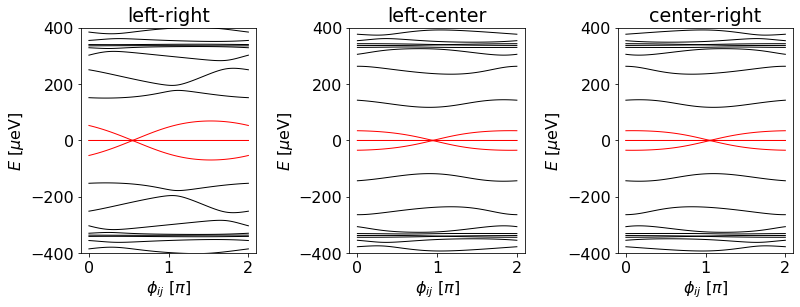

In [210]:
fig, ax = plt.subplots(ncols=3, figsize=(11, 4))
fig.tight_layout(h_pad=1, w_pad=3)

i = 0
for spectra in spectras:
    j = 0
    for level in spectra.T:
        ax[i].plot(phases/np.pi, 1e6*level, c=colors[j], linewidth=1)
        j += 1
    ax[i].set_xlabel(r'$\phi_{ij}$ [$\pi$]')
    ax[i].set_ylabel(r'$E$ [$\mu$eV]')
    ax[i].set_title(titles[i])
    ax[i].set_ylim(-400, 400)
    i += 1

## Long junction

In [186]:
width = 20*a
center = [-width/4, width/4]
geometry = {
    "l": 130*a,
    "w": 7*a,
    "a": a,
    "side": 'up',
    "shape": 'rectangle',
    "L": 100*a,
    "W": width,
    "centers": center
}

In [187]:
trijunction, f_params, _ = tj.finite_system(**geometry)
trijunction = trijunction.finalized()

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


(-1e-07, 1.1e-06)

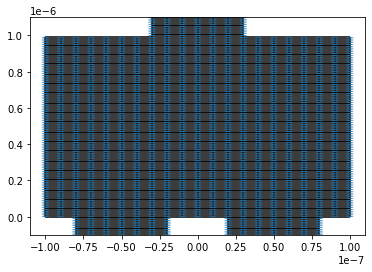

In [188]:
fig, ax = plt.subplots()
kwant.plot(trijunction, ax=ax)
ax.set_ylim(-1e-7, 11e-7)

In [189]:
n = 60
system = [trijunction, f_params]
eigen = sl.general_solver([system], n)


def wrap(args):
    return eigen(*args)

In [190]:
extra_params = sl.phase_params(key='sigma', param=0)

In [191]:
args = list(it.product([0], extra_params))
args_db = db.from_sequence(args, npartitions=20)

In [192]:
with Cluster(options) as cluster:
    cluster.scale(n=20)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

path = directory_path + '/long_junction.pickle'
with open(path, 'wb') as file:
    pickle.dump(result, file)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/15450d9347fb48c093e1b3c531b149a0/status


distributed.comm.tcp - WARNING - Closing dangling stream in <TLS  local=tls://127.0.0.1:39396 remote=gateway://localhost:8000/15450d9347fb48c093e1b3c531b149a0>


In [193]:
with open(directory_path+'/long_junction.pickle', 'rb') as data:
    result = pickle.load(data)

In [196]:
dat_13, dat_12, dat_23 = tl.separate_data_wires(result)

en_13, _ = tl.separate_energies_wfs(dat_13)
en_12, _ = tl.separate_energies_wfs(dat_12)
en_23, _ = tl.separate_energies_wfs(dat_23)

spectras = np.array([en_13, en_12, en_23])

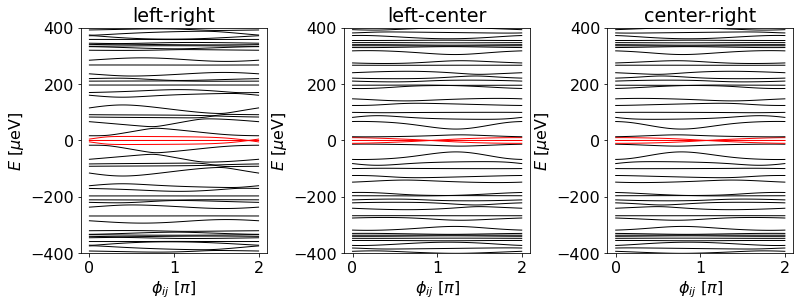

In [206]:
fig, ax = plt.subplots(ncols=3, figsize=(11, 4))
fig.tight_layout(h_pad=1, w_pad=2)

i = 0
for spectra in spectras:
    j = 0
    for level in spectra.T:
        ax[i].plot(phases/np.pi, 1e6*level, c=colors[j], linewidth=1)
        j += 1
    ax[i].set_xlabel(r'$\phi_{ij}$ [$\pi$]')
    ax[i].set_ylabel(r'$E$ [$\mu$eV]')
    ax[i].set_title(titles[i])
    ax[i].set_ylim(-400, 400)
    i += 1

# Spin orbit dependence

In [211]:
width = 20*a
center = [-width/4, width/4]
geometry = {
    "l": 130*a,
    "w": 7*a,
    "a": a,
    "side": 'up',
    "shape": 'rectangle',
    "L": 15*a,
    "W": width,
    "centers": center
}

In [212]:
trijunction, f_params, _ = tj.finite_system(**geometry)
trijunction = trijunction.finalized()

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


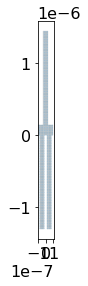

In [213]:
kwant.plot(trijunction);

In [214]:
key = 'mu_qd'
n = 6
system = [trijunction, f_params]
eigen = sl.general_solver([system], n)


def wrap(args):
    return eigen(*args)

In [218]:
# make parameters for each alpha
alphas = np.linspace(3e-12, 3e-11, 50, endpoint=True)
alphas_phases = []
for alpha in alphas:
    alphas_phases.append(sl.phase_params(key='alpha', param=alpha))

## Single example

In [10]:
args = list(it.product([0], alphas_phases[2]))
args_db = db.from_sequence(args, npartitions=20)

In [11]:
with Cluster(options) as cluster:
    cluster.scale(n=20)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/1409a10d6d1f4fd98416dfa119d1af87/status


In [12]:
couplings, _, _ = tl.coupling_data(result)

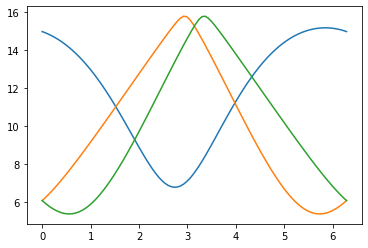

In [14]:
phases = np.linspace(0, 2*np.pi, 100)
for coupling in couplings:
    plt.plot(phases, 1e6*coupling)

In [23]:
couplings = np.array(couplings)
phases[np.argmax(couplings, axis=1)]/np.pi

array([1.85858586, 0.92929293, 1.07070707])

## SO dependence

In [220]:
phis = np.linspace(0, 2*np.pi, 100)
all_couplings = []
maxs = []

with Cluster(options) as cluster:
    cluster.scale(n=20)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    for phases in alphas_phases:
        args = list(it.product([0], phases))
        args_db = db.from_sequence(args, npartitions=20)
        result = args_db.map(wrap).compute()

        couplings, _, _ = tl.coupling_data(result)
        couplings = np.array(couplings)

        maxs.append(phis[np.argmax(couplings, axis=1)]/np.pi)
        all_couplings.append(couplings)

    maxs = np.array(maxs)
    all_couplings = np.array(all_couplings)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/a4164e3b1e9b48d7ba6e685039ec708a/status


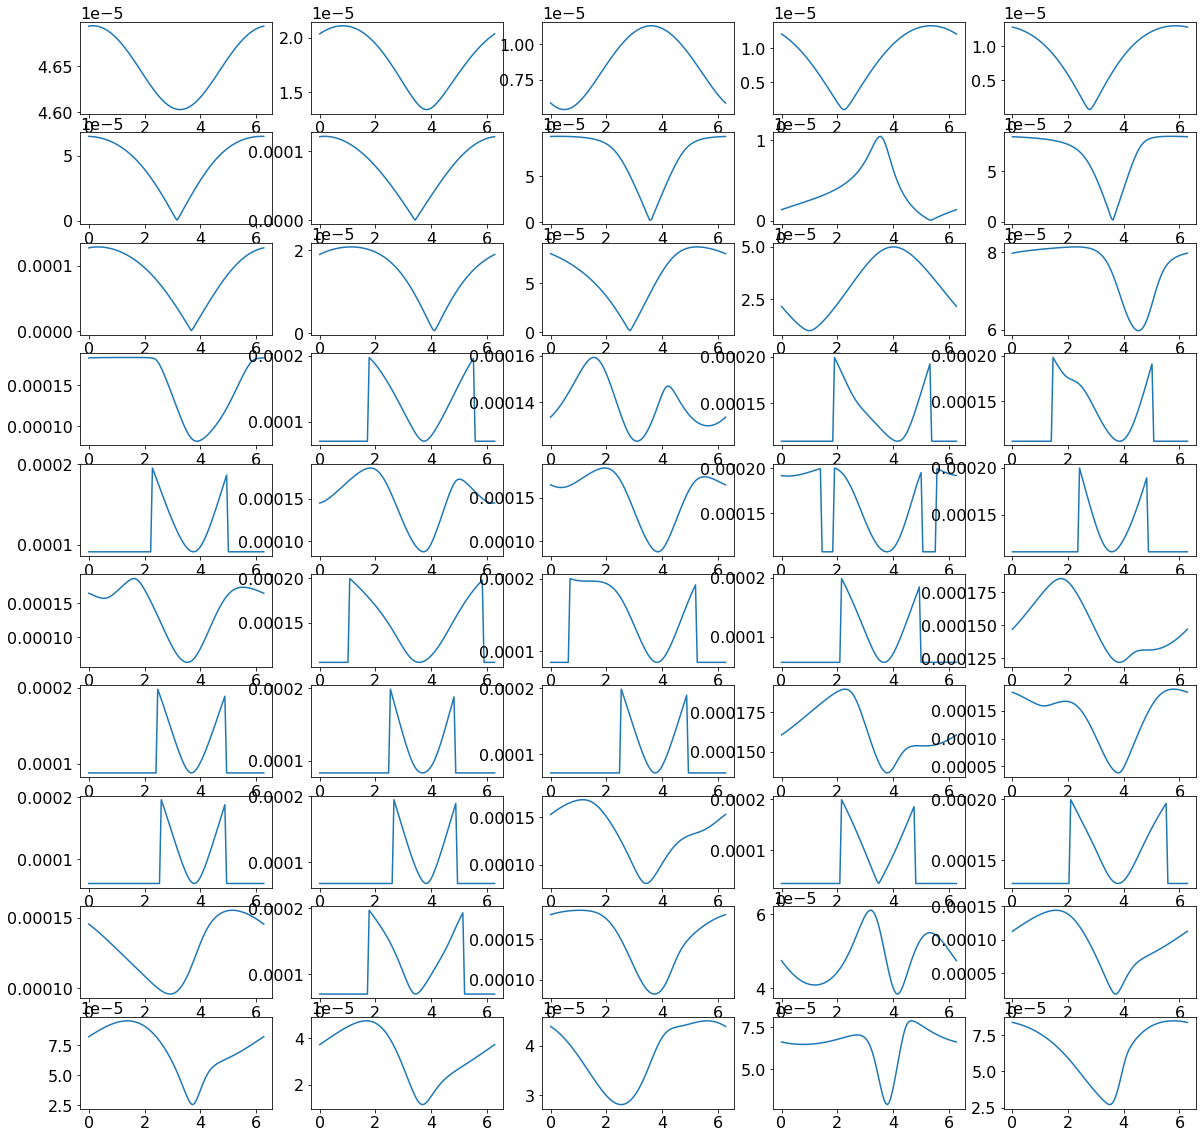

In [237]:
fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(20, 20))
pair = 1
i = 0
for ax in axes.flatten():
    ax.plot(phis, all_couplings[i][pair])
    i += 1

In [266]:
maxs

array([[1.07070707, 0.04040404, 1.95959596],
       [1.21212121, 0.26262626, 1.73737374],
       [1.43434343, 1.15151515, 0.84848485],
       [0.74747475, 1.71717172, 0.28282828],
       [1.49494949, 1.85858586, 0.14141414],
       [1.49494949, 1.97979798, 0.02020202],
       [1.27272727, 0.06060606, 1.93939394],
       [0.76767677, 0.1010101 , 1.8989899 ],
       [1.95959596, 1.13131313, 0.86868687],
       [1.53535354, 1.81818182, 0.18181818],
       [1.39393939, 0.1010101 , 1.8989899 ],
       [1.21212121, 0.36363636, 1.63636364],
       [0.44444444, 1.67676768, 0.32323232],
       [0.04040404, 1.27272727, 0.72727273],
       [1.7979798 , 0.72727273, 1.27272727],
       [0.36363636, 0.46464646, 1.53535354],
       [0.70707071, 0.56565657, 0.22222222],
       [0.78787879, 0.48484848, 1.51515152],
       [0.64646465, 0.60606061, 0.28282828],
       [0.96969697, 0.46464646, 0.38383838],
       [0.78787879, 0.72727273, 0.4040404 ],
       [1.97979798, 0.58585859, 1.41414141],
       [0.

# Nanowire position dependence

In [71]:
width = 80*a
geometry = {
    "l": 130*a,
    "w": 7*a,
    "a": a,
    "side": 'up',
    "shape": 'rectangle',
    "L": 15*a,
    "W": width
}

In [72]:
n_geometries = 10
centers = np.linspace([width/4, -(width/4-10*a)], [width/4, -(width/4+10*a)], n_geometries)

In [73]:
tjs_width = []
for center in centers:
    geometry.update(centers=center)
    trijunction, f_params, _ = tj.finite_system(**geometry)
    trijunction = trijunction.finalized()
    tjs_width.append([trijunction, f_params])

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecati

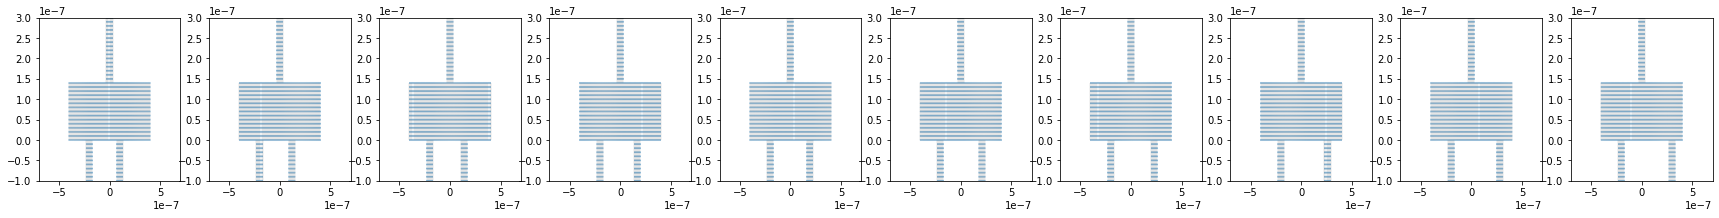

In [74]:
fig, ax = plt.subplots(ncols=n_geometries, nrows=1, figsize=(3*n_geometries, 3))
i = 0
for axes in ax.flatten():
    kwant.plot(tjs_width[i][0], ax=axes)
    axes.set_ylim(-1e-7, 3e-7)
    axes.set_xlim(-7e-7, 7e-7)
    i += 1

In [75]:
key = 'mu_qd'
n = 6
eigen = sl.general_solver(tjs_width, n)


def wrap(args):
    return eigen(*args)

In [76]:
phases = sl.phase_params(key='sigma', param=0)
args = list(it.product(range(n_geometries), phases))
args_db = db.from_sequence(args, npartitions=20)

In [77]:
with Cluster(options) as cluster:
    cluster.scale(n=20)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/50a90de23fd0460caf1cd4e710530180/status


In [78]:
geometries_couplings = []

data_geometries = tl.separate_data_geometries(data=result, n_geometries=n_geometries)
for geometry in data_geometries:
    couplings, _, _ = tl.coupling_data(data=geometry, sign=1, prominence=0, n_peaks=0)
    geometries_couplings.append(couplings)

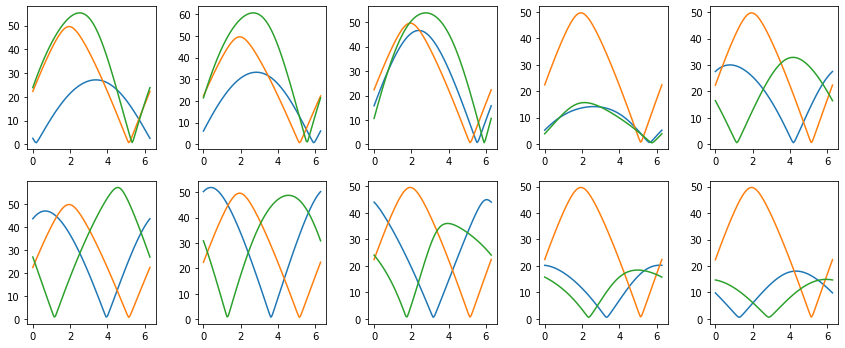

In [79]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 5))
fig.tight_layout()
i = 0
for ax in axes.flatten():
    for coup in geometries_couplings[i]:
        ax.plot(phis, 1e6*coup)
    i += 1

# Rectangular strip

In [221]:
geometry = {
    "l": 130*a,
    "w": 7*a,
    "a": a,
    "side": 'down',
    "shape": 'rectangle',
    "L": 15*a,
    "W": 154*a
}

In [222]:
n_geometries = 50
distances = np.linspace(10*a, 70*a, n_geometries)

## Calculation

In [243]:
tjs = []
for distance in distances:
    geometry.update(centers=[distance, -distance])
    trijunction, f_params, _ = tj.finite_system(**geometry)
    trijunction = trijunction.finalized()
    tjs.append([trijunction, f_params])

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecati

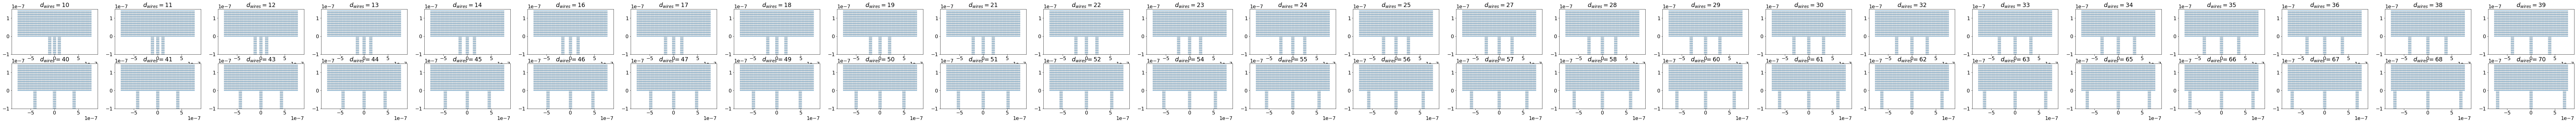

In [244]:
fig, ax = plt.subplots(ncols=int(n_geometries/2), nrows=2, figsize=(3*n_geometries, 6))
i = 0
for axes in ax.flatten():
    kwant.plot(tjs[i][0], ax=axes)
    axes.set_ylim(-1e-7, 1.5e-7)
    axes.set_title(r'$d_{wires}=$'+str(int(distances[i]/a)))
    axes.set_xlim(-9e-7, 9e-7)
    #axes.set_title(r'$\theta/\pi$='+str(np.round(angles[i], 3)))
    i += 1

In [245]:
n = 6
eigen = sl.general_solver(tjs, n)


def wrap(args):
    return eigen(*args)

In [246]:
n = 6
eigen = sl.general_solver(tjs=geometries, n)


def wrap(args):
    return eigen(*args)


phases = sl.phase_params(key='mu_qd', param=0)
args = list(it.product(range(n_geometries), phases))
args_db = db.from_sequence(args, npartitions=40)


with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("Optimal phases dashboard: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

maxs = []

data_geometries = tl.separate_data_geometries(data=result, n_geometries=n_geometries)
for geometry in data_geometries:
    couplings, _, _ = tl.coupling_data(data=geometry, sign=1, prominence=0, n_peaks=1, n=40)
    maxs.append(phis[np.argmax(couplings, axis=1)]/np.pi)

maxs = np.array(maxs)

In [247]:
with Cluster(options) as cluster:
    cluster.scale(n=40)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

    result = args_db.map(wrap).compute()

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/059525c3f0a543a19dc071b2f6d88b5d/status


In [267]:
geometries_couplings = []
geometries_peaks = []
maxs = []

data_geometries = tl.separate_data_geometries(data=result, n_geometries=n_geometries)
for geometry in data_geometries:
    couplings, _, peaks = tl.coupling_data(data=geometry, sign=1, prominence=0, n_peaks=1, n=40)
    geometries_couplings.append(couplings)
    geometries_peaks.append(peaks)
    maxs.append(phis[np.argmax(couplings, axis=1)]/np.pi)

geometries_couplings = np.array(geometries_couplings)
geometries_peaks = np.array(geometries_peaks)
maxs = np.array(maxs)

In [268]:
geometries = 1e10*distances
pair = 0

mus_qd_units = phis/np.pi

In [269]:
geometries_couplings.shape

(50, 3, 100)

In [270]:
title = r'$d_{wires}$ = '
units = r'[nm]'

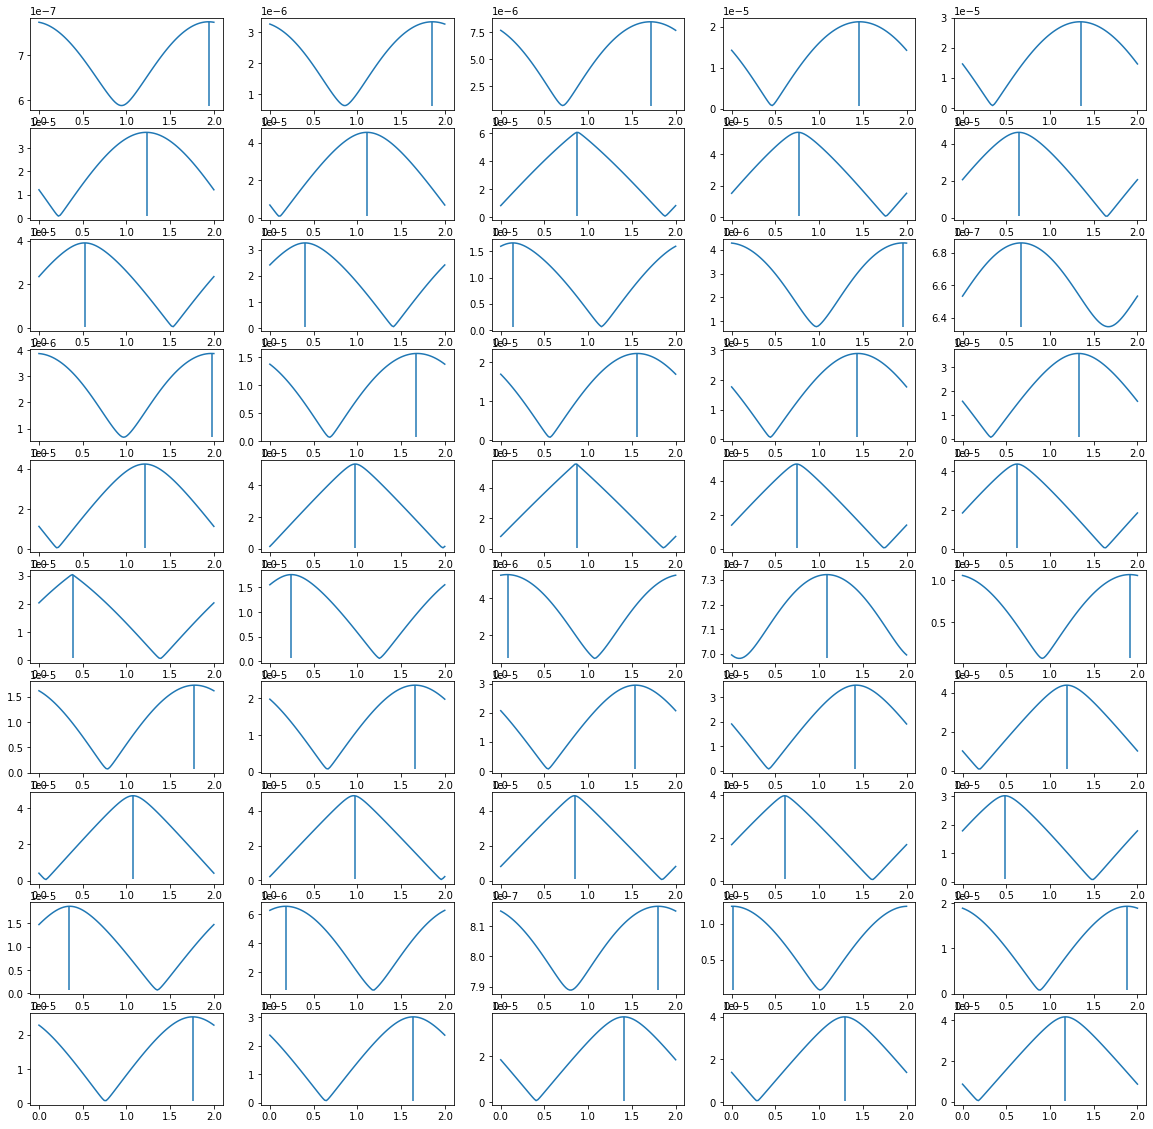

In [276]:
fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(20, 20))
pair = 0
i = 0
for ax in axes.flatten():
    ax.plot(phis/np.pi, geometries_couplings[i][pair])
    mx = np.max(geometries_couplings[i][pair])
    mn = np.min(geometries_couplings[i][pair])
    ax.vlines(x=maxs.T[pair][i], ymin=mn, ymax=mx)
    i += 1

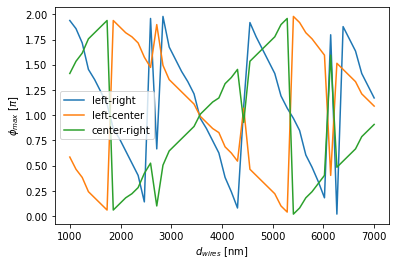

In [286]:
i = 0
for level in maxs.T:
    plt.plot(1e10*distances, level, label=titles[i])
    i += 1
plt.xlabel(r'$d_{wires}$ [nm]')
plt.ylabel(r'$\phi_{max}$ [$\pi$]')
plt.legend()

In [ ]:
def max_phases(geometries, mu_qd0=0, npts=100):
    n = 6
    eigen = sl.general_solver(tjs=geometries, n)
    phis = np.linspace(0, 2*np.pi, npts)


    def wrap(args):
        return eigen(*args)


    phases = sl.phase_params(key='mu_qd', param=mu_qd0)
    args = list(it.product(range(n_geometries), phases))
    args_db = db.from_sequence(args, npartitions=40)


    with Cluster(options) as cluster:
        cluster.scale(n=40)
        client = cluster.get_client()
        print("Optimal phases dashboard: http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

        result = args_db.map(wrap).compute()

    maxs = []

    data_geometries = tl.separate_data_geometries(data=result, n_geometries=n_geometries)
    for geometry in data_geometries:
        couplings, _, _ = tl.coupling_data(data=geometry, sign=1, prominence=0, n_peaks=1, n=40)
        maxs.append(phis[np.argmax(couplings, axis=1)]/np.pi)

    maxs = np.array(maxs)
    return maxs